# Merging Datasets to fill in **Address** Feature.

Previous **no_dupe_df.csv** has 813 addresses listed as "No primary address specified".

**[Data Dictionary](https://data.wprdc.org/dataset/condemned-properties/resource/0a963f26-eb4b-4325-bbbc-3ddf6a871410)** lists that the missing street address could be found in the [Allegheny County Property Assessments table](https://data.wprdc.org/dataset/property-assessments), which we will combine to see.

With 460 of the properties (condemned and dead-end) being owned by the City of Pittsburgh, we can also combine it with the [City-Owned Properties](https://data.wprdc.org/dataset/city-owned-properties/resource/e1dcee82-9179-4306-8167-5891915b62a7) dataset.

### **Datasets Needed (City Property):**

- **merged_df.csv** (our data after merging with Allegheny County Property Assessments Table data of addresses)
- **city_owned_property.csv** (City Owned Properties Dataset)



# **Bring in our original dataset**


In [ ]:
# importing libraries
import pandas as pd               # data preprocessing
import numpy as np                # to work with #'s & arrays
import matplotlib.pyplot as plt   # more for graphing/visualizations

# Next: Find these addresses from the City Properties Dataset.

In this dataset the **merged_df**'s parcel_id matches the new dataset's 'County parcel identifier' column.

In [ ]:
merged_df = "merged_df.csv"
df = pd.read_csv(merged_df)
df.head(2)

,_id,parcel_id,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,final_address
0,332079,0001G00106000000,BOULEVARD & MARKET LLC,Condemned Property,Pass,Active,2023-11-29,00:00:00,1,"108 MARKET ST, Pittsburgh, PA 15222"
1,332078,0001G00107000000,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1,"100 MARKET ST, PITTSBURGH, PA 15222"


In [ ]:
# bring in the file
city = "city_owned_property.csv"
city_df = pd.read_csv(city)
city_df.head(3)                                         # sanity check - first 3

,_id,id,pin,address,owner,parc_sq_ft,class,zoned_as,inventory_type,current_status,...,longitude,census_tract,neighborhood_name,council_district,ward,fire_zone,police_zone,dpw_streets,dpw_enviro,dpw_parks
0,5984485,173844,0024G00060000000,1249 51 VOSKAMP ST,City of Pittsburgh,5700.0,Vacant Land,R1A-M,Hold for Study,Hold for Study,...,-79.989350,4.200324e+10,Troy Hill,1.0,24.0,1-5,1.0,1.0,Northern,Northern
1,5984486,184781,0050E00015000000,408 N MATHILDA ST,City of Pittsburgh,756.0,Vacant Land,R1A-H,Public Sale,Sale Pending,...,-79.945632,4.200310e+10,Garfield,9.0,10.0,3-4,5.0,2.0,Central,Highland
2,5984487,177194,0083J00136000000,5511 BROAD ST,City of Pittsburgh,3000.0,Vacant Land,R2-H,Public Sale,Sale Pending,...,-79.931200,4.200311e+10,Garfield,9.0,11.0,3-4,5.0,2.0,Central,Highland


In [ ]:
city_df.columns

Index(['_id', 'id', 'pin', 'address', 'owner', 'parc_sq_ft', 'class',
       'zoned_as', 'inventory_type', 'current_status', 'acquisition_method',
       'acquisition_date', 'last_updated', 'latitude', 'longitude',
       'census_tract', 'neighborhood_name', 'council_district', 'ward',
       'fire_zone', 'police_zone', 'dpw_streets', 'dpw_enviro', 'dpw_parks'],
      dtype='object')

We only need the **pin** and **address**

In [ ]:
# keep features I want from the city dataset
city_df = city_df[['pin', 'address', 'owner', 'acquisition_date']].copy()
city_df['date'] = pd.to_datetime(city_df['acquisition_date']).dt.date # make into datetime dtype
city_df.drop(columns = ['acquisition_date'], inplace = True)          # drop old date
city_df.rename(columns={'owner': 'city_owner'}, inplace=True)         # rename owner so we don't get confused

city_df.head(5)

,pin,address,city_owner,date
0,0024G00060000000,1249 51 VOSKAMP ST,City of Pittsburgh,NaT
1,0050E00015000000,408 N MATHILDA ST,City of Pittsburgh,2015-10-30
2,0083J00136000000,5511 BROAD ST,City of Pittsburgh,1995-04-24
3,0124G00073000000,6407 DEAN ST,City of Pittsburgh,2011-07-29
4,0125B00027000000,603 LINCOLN AV,City of Pittsburgh,2013-04-26


In [ ]:
# parcel ids I want from this dataset - match original data pids
pids = set(df['parcel_id'])

# we set the parcel_id above as a var --> pids
city_df = city_df[city_df['pin'].isin(pids)] # only keep with same pids
print(city_df['city_owner'].unique())
print(len(city_df))                           # city owned 460

['City of Pittsburgh']
470


There's more than there should be, check for duplicates.

In [ ]:
# count of duplicate parcel_id's
pin_count = city_df['pin'].value_counts()
dup_pin = pin_count[pin_count > 1].index.tolist() # filter to pins with more thn 1 entry to list
print(f"\nList of Duplicate PINS's: {dup_pin}\nNumber of Duplicate PIN's: {len(dup_pin)}")



List of Duplicate PINS's: []
Number of Duplicate PIN's: 0


In [ ]:
city_props_df = df[df['owner'] == "CITY OF PITTSBURGH"].copy()
print(len(city_props_df))

460


No duplicates, and everything else is normal. Check for the specific rows that don't match up with our original dataset.


In [ ]:
city_df_pins = set(city_df['pin'])                # new data
city_props_pids = set(city_props_df['parcel_id']) # original data

extra_pins = city_df_pins - city_props_pids       # the outliers
print(f"{len(extra_pins)} parcel id in city_df but not in city_props_df:")   # should be 10
print(extra_pins)                                 # print the outlier pids/pins

# info from the merged df --> figure out what's going on
print("\nparcel ids with different owners:")
subset = df.loc[df['parcel_id'].isin(extra_pins),['parcel_id', 'owner', 'final_address']]
subset.head(28)

28 parcel id in city_df but not in city_props_df:
{'0045E00331000000', '0057G00191000000', '0014A00262000000', '0046N00197000000', '0026J00075000000', '0050C00031000000', '0027A00126000000', '0023F00180000000', '0014A00224000000', '0014C00045000000', '0014A00250000000', '0028E00163000000', '0023F00175000000', '0027B00095000A00', '0026P00185000000', '0124P00011000A00', '0003P00180000000', '0002P00120000000', '0094N00037000000', '0046S00156000000', '0004J00178000000', '0174B00109000000', '0055K00224000000', '0015R00225000000', '0051J00229000000', '0124P00266000000', '0027B00318000000', '0175C00235000000'}

parcel ids with different owners:


,parcel_id,owner,final_address
18,0002P00120000000,2P110 CARES INC,"700 2ND AVE #533, Pittsburgh, PA 15219"
30,0003P00180000000,KURNIKOV IGOR,"715 MCLAIN ST, Pittsburgh, 15210"
50,0004J00178000000,M&Y PITTSBURGH ROOMS LLC,"502 NATCHEZ ST, Pittsburgh, 15211"
392,0014A00224000000,GRANDVIEW SOUTH HOMES LP,"618 EXCELSIOR ST, Pittsburgh, 15210"
396,0014A00250000000,GRANDVIEW SOUTH HOMES LP,"615 EXCELSIOR ST, Pittsburgh, 15210"
397,0014A00262000000,3374 MSTREET LLC,"46 MILLBRIDGE ST, Pittsburgh, 15210"
410,0014C00045000000,STONEGATE INVESTMENT REALTY LLC,"952 EXCELSIOR ST, Pittsburgh, 15210"
668,0015R00225000000,BEY-ATTORNEY AT LAW SOLO 401 K TRUST,"836 GEARING AVE, Pittsburgh, 15210"
882,0023F00175000000,SNINSKY RONALD D,"115 E JEFFERSON ST, Pittsburgh, PA 15212"
883,0023F00180000000,FRANK QUINN CONSTRUCTION CORPORATION,"108 CARRINGTON ST, Pittsburgh, PA 15212"


The owners of our dataset seem to be conflicting with what the city dataset is claiming.

**Insight:**
- In our original *cleaned* data, City of Pittsburgh owned 460 properties
- The dataset claims that 470 of the properties are owned by the City of Pittsburgh
- 28 of the properties are claimed to be owned by the City of Pittsburgh when listed to be owned by another individual.


## Data with ONLY matching entries from city properties data (470 rows)
Just combining the rows with the same parcel_ids --> we can add it back to the main df later

In [ ]:
# merging city info to original df
copy_df = df.copy()

# make sure date into datetime dtype
copy_df['new_date'] = pd.to_datetime(copy_df['new_date']).dt.date

# inner join - all pids that match
combined = copy_df.merge(city_df[['pin', 'address', 'city_owner', 'date']],
                         how = 'inner', left_on = 'parcel_id', right_on = 'pin')

# filter to final_owner by comparing the date of the entries since the some owner entries are differing
combined['final_owner'] = np.where(combined['new_date'] > combined['date'],   # compare the dates
                                   combined['owner'], combined['city_owner']) # owner if new date, city_owner if date

# filter to final_date for what was used to determine final_owner - same way
combined['final_date'] = np.where(combined['new_date'] > combined['date'],
                                  combined['new_date'], combined['date'])

combined

,_id,parcel_id,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,final_address,pin,address,city_owner,date,final_owner,final_date
0,334551,0002P00120000000,2P110 CARES INC,Condemned Property,Fail,Inactive,2024-06-05,00:00:00,1,"700 2ND AVE #533, Pittsburgh, PA 15219",0002P00120000000,700.02 SECOND AV,City of Pittsburgh,1994-09-22,2P110 CARES INC,2024-06-05
1,332810,0003P00180000000,KURNIKOV IGOR,Condemned Property,Fail,Inactive,2021-06-24,00:00:00,1,"715 MCLAIN ST, Pittsburgh, 15210",0003P00180000000,715 MCLAIN ST,City of Pittsburgh,2016-10-28,KURNIKOV IGOR,2021-06-24
2,332439,0003R00321000000,CITY OF PITTSBURGH,Condemned Property,Fail,Inactive,2020-07-15,00:00:00,1,"919 EUREKA ST, Pittsburgh, 15210",0003R00321000000,919 EUREKA ST,City of Pittsburgh,2016-10-28,CITY OF PITTSBURGH,2020-07-15
3,333782,0004J00178000000,M&Y PITTSBURGH ROOMS LLC,Condemned Property,Fail,Active,2020-09-08,00:00:00,1,"502 NATCHEZ ST, Pittsburgh, 15211",0004J00178000000,502 NATCHEZ ST,City of Pittsburgh,2015-04-24,M&Y PITTSBURGH ROOMS LLC,2020-09-08
4,333735,0004N00169000000,CITY OF PITTSBURGH,Condemned Property,Fail,Active,2020-09-03,00:00:00,1,"28 MARNE Way, Pittsburgh, PA 15211",0004N00169000000,28 MARNE WAY,City of Pittsburgh,2016-04-29,CITY OF PITTSBURGH,2020-09-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,331206,0184N00234000000,CITY OF PITTSBURGH,Condemned Property,Pass,Inactive,2020-09-04,00:00:00,1,"1149 MARGRAY ST, PITTSBURGH, PA 15207",0184N00234000000,1149 MARGRAY ST,City of Pittsburgh,2020-12-18,City of Pittsburgh,2020-12-18
466,333803,0231F00009000000,CITY OF PITTSBURGH,Condemned Property,Fail,Active,2020-09-08,00:00:00,1,"8517 PERSHING ST, Pittsburgh, 15235",0231F00009000000,8517 PERSHING ST,City of Pittsburgh,2010-10-22,CITY OF PITTSBURGH,2020-09-08
467,333780,0231K00232000000,CITY OF PITTSBURGH,Condemned Property,Fail,Inactive,2020-09-08,00:00:00,1,No primary address specified,0231K00232000000,8373 VIDETTE STREET,City of Pittsburgh,2023-10-27,City of Pittsburgh,2023-10-27
468,333431,0231P00039000000,CITY OF PITTSBURGH,Condemned Property,Fail,Active,2020-07-24,00:00:00,1,"8220 FAHNESTOCK ST, Pittsburgh, 15221",0231P00039000000,8220 FAHNESTOCK AVE,City of Pittsburgh,2019-04-18,CITY OF PITTSBURGH,2020-07-24


In [ ]:
num_changed = combined['final_owner'].ne(combined['owner']).sum()   # not-equal method
print(f"# of records where owner was replaced: {num_changed}")

# of records where owner was replaced: 87


In [ ]:
no_add = "No primary address specified"   # var for reuse

# update final_address if final_add is no add & the new add column is valid
combined['final_address'] = np.where((combined['final_address'] == no_add) & (combined['address'] != no_add),
                                     combined['address'], combined['final_address'])

combined.head()

,_id,parcel_id,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,final_address,pin,address,city_owner,date,final_owner,final_date
0,334551,0002P00120000000,2P110 CARES INC,Condemned Property,Fail,Inactive,2024-06-05,00:00:00,1,"700 2ND AVE #533, Pittsburgh, PA 15219",0002P00120000000,700.02 SECOND AV,City of Pittsburgh,1994-09-22,2P110 CARES INC,2024-06-05
1,332810,0003P00180000000,KURNIKOV IGOR,Condemned Property,Fail,Inactive,2021-06-24,00:00:00,1,"715 MCLAIN ST, Pittsburgh, 15210",0003P00180000000,715 MCLAIN ST,City of Pittsburgh,2016-10-28,KURNIKOV IGOR,2021-06-24
2,332439,0003R00321000000,CITY OF PITTSBURGH,Condemned Property,Fail,Inactive,2020-07-15,00:00:00,1,"919 EUREKA ST, Pittsburgh, 15210",0003R00321000000,919 EUREKA ST,City of Pittsburgh,2016-10-28,CITY OF PITTSBURGH,2020-07-15
3,333782,0004J00178000000,M&Y PITTSBURGH ROOMS LLC,Condemned Property,Fail,Active,2020-09-08,00:00:00,1,"502 NATCHEZ ST, Pittsburgh, 15211",0004J00178000000,502 NATCHEZ ST,City of Pittsburgh,2015-04-24,M&Y PITTSBURGH ROOMS LLC,2020-09-08
4,333735,0004N00169000000,CITY OF PITTSBURGH,Condemned Property,Fail,Active,2020-09-03,00:00:00,1,"28 MARNE Way, Pittsburgh, PA 15211",0004N00169000000,28 MARNE WAY,City of Pittsburgh,2016-04-29,CITY OF PITTSBURGH,2020-09-03


In [ ]:
print((combined['final_address'] == no_add).sum())  # print # of entries with no add in this data

0


In [ ]:
# remove all unnecessary columns
combined.drop(columns = ['pin', 'city_owner', 'owner', 'date', 'new_date', 'address'], inplace = True)
combined.head(5)

,_id,parcel_id,property_type,latest_inspection_result,inspection_status,new_time,score,final_address,final_owner,final_date
0,334551,0002P00120000000,Condemned Property,Fail,Inactive,00:00:00,1,"700 2ND AVE #533, Pittsburgh, PA 15219",2P110 CARES INC,2024-06-05
1,332810,0003P00180000000,Condemned Property,Fail,Inactive,00:00:00,1,"715 MCLAIN ST, Pittsburgh, 15210",KURNIKOV IGOR,2021-06-24
2,332439,0003R00321000000,Condemned Property,Fail,Inactive,00:00:00,1,"919 EUREKA ST, Pittsburgh, 15210",CITY OF PITTSBURGH,2020-07-15
3,333782,0004J00178000000,Condemned Property,Fail,Active,00:00:00,1,"502 NATCHEZ ST, Pittsburgh, 15211",M&Y PITTSBURGH ROOMS LLC,2020-09-08
4,333735,0004N00169000000,Condemned Property,Fail,Active,00:00:00,1,"28 MARNE Way, Pittsburgh, PA 15211",CITY OF PITTSBURGH,2020-09-03


### Merge the data back together

In [ ]:
# data consistency
df['new_date'] = pd.to_datetime(df['new_date']) # before moving date changes - final date is datetime dtype

# index combined by parcel_id
combined_index = combined.set_index('parcel_id')

# defined city_props_pids before -- index combined by parcel_id
df['owner']    = df['parcel_id'].map(combined_index['final_owner']).fillna(df['owner'])    # update owner
df['new_date'] = df['parcel_id'].map(combined_index['final_date']).fillna(df['new_date'])  # update date
df['final_address'] = df['parcel_id'].map(combined_index['final_address']).fillna(df['final_address'])  # update address
df


,_id,parcel_id,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,final_address
0,332079,0001G00106000000,BOULEVARD & MARKET LLC,Condemned Property,Pass,Active,2023-11-29 00:00:00,00:00:00,1,"108 MARKET ST, Pittsburgh, PA 15222"
1,332078,0001G00107000000,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29 00:00:00,00:00:00,1,"100 MARKET ST, PITTSBURGH, PA 15222"
2,332077,0001G00109000000,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29 00:00:00,00:00:00,1,"100 MARKET ST, PITTSBURGH, PA 15222"
3,332076,0001H00046000000,TROY DEVELOPMENT ASSOCIATES,Condemned Property,Pass,Active,2023-11-29 00:00:00,00:00:00,1,"209 1ST AVE, Pittsburgh, 15222"
4,332402,0001H00216000000,PITTSBURGH REAL ESTATE COMPANY LLC,Condemned Property,Fail,Active,2020-06-04 00:00:00,00:00:00,1,"5 MARKET SQ, Pittsburgh, 15222"
...,...,...,...,...,...,...,...,...,...,...
2797,333598,0232B00161000000,ATL HOLDINGS LLC,Condemned Property,Fail,Active,2020-08-27 00:00:00,00:00:00,1,"1721 CRESTLINE ST, Pittsburgh, 15221"
2798,333597,0232B00290000000,BROWN FRANCES R,Condemned Property,Fail,Active,2020-08-27 00:00:00,00:00:00,1,"619 DORNBUSH ST, Pittsburgh, PA 15221"
2799,334416,0232C00004000000,City of Pittsburgh,Condemned Property,Fail,Active,2021-10-15,00:00:00,1,"2053 FRANKELLA AVE, Pittsburgh, 15221"
2800,332555,0232F00158000000,HUC ONE LLC,Condemned Property,Fail,Inactive,2020-08-27 00:00:00,00:00:00,1,"1719 CRESTLINE ST, Pittsburgh, 15221"


In [ ]:
# check # of no address columns now
count = len(df[df['final_address'] == "No primary address specified"])
print(count)

509


### **Insights**
- Filled in all 138 entries with matching ID's from City Property dataset that matched up with our parcel ID to update the 'No primary address specified' out of 470 entries.
- 87 entries' out of the 470 owners were updated based on the date of the entry.
- Lowered 647 missing address entries to 509. (saved in final_draft_df.csv) -- this is 647 - 138

**This info is in the original dataset concantenating file**
- 28 rows of data had different owner, and some had valid addresses.
- Out of the 28, 5 rows did not match the owner (shown above) and lacked a valid address, while the rest, 13 rows, had a valid address but differing owners.



**Currently**
- **merged_df** is our original data from after merging with the allegheny dataset
- **combined_city_data** has all features of the 470 entries with matching pids from original df, no merging addresses (shows the original differences)
- **final_draft_df** has the addresses of the new dataset combined except for the contrasting owners --> *saved to final_draft_df.csv* below


In [ ]:
df.to_csv('final_draft_df.csv', index = False)

**city_df_470.csv** saved for only working with data related to our parcel_id in condemned/dead-end properties dataset for reference.
- Features: ['pin', 'address', 'owner']

In [ ]:
city_df.to_csv('city_df_470.csv', index = False)

# Score 4 Properties Addresses

### Before the addresses were added in - View in EDA/Data Cleaning File

No address was available

### After the addresses were added in:

In [ ]:
# records with score = 4
new_score4 = df[df['score'] == 4]
new_score4

,_id,parcel_id,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score,final_address
807,330336,0022F00119000000,CITY OF PITTSBURGH,Condemned Property,Fail,Inactive,2020-09-10,00:00:00,4,"1406 WARNER ST, PITTSBURGH, PA 15233"
1537,330329,0047E00052000000,GILL JOHN,Condemned Property,Fail,Inactive,2020-09-04 00:00:00,00:00:00,4,"913 MINA ST, PITTSBURGH, PA 15212"
2791,330285,0232A00021000000,GARDNER LUELLA B,Condemned Property,Fail,Inactive,2020-07-10 00:00:00,00:00:00,4,No primary address specified


We were able to get 2 of the high-risk properties addresses.

Since the inspection status is inactive, we could push for obtaining private demolition permit or a building permit to repair.

Final missing address counts.

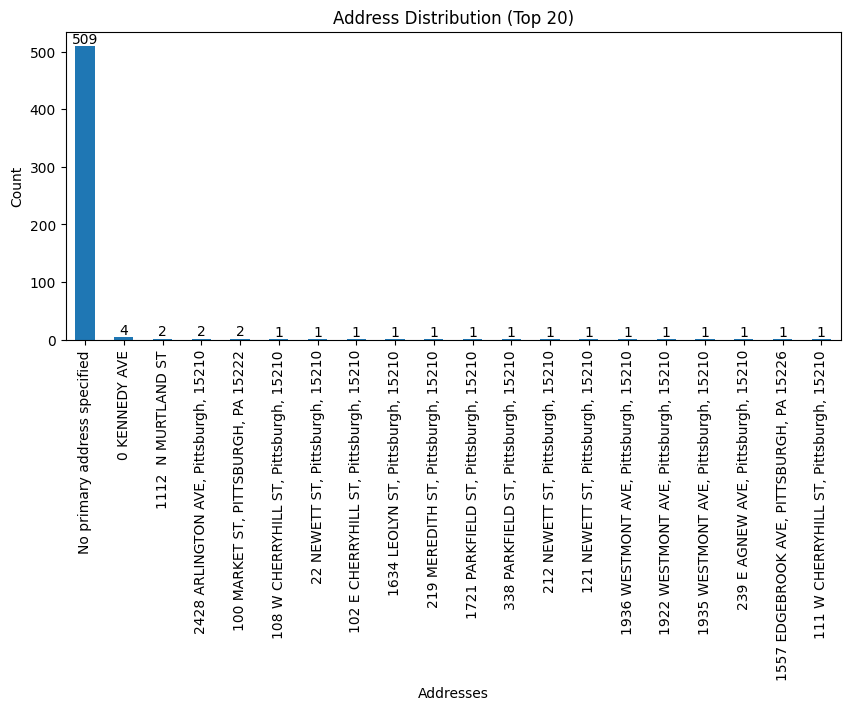

In [ ]:
# address counts
add_counts = df['final_address'].value_counts().nlargest(20)
# plot and label bars
add_graph = add_counts.plot(kind='bar', figsize=(10,4))
add_graph.bar_label(add_graph.containers[0])        # add the count labels
# design / details
plt.title('Address Distribution (Top 20)')
plt.xlabel("Addresses")
plt.ylabel('Count')
plt.show()

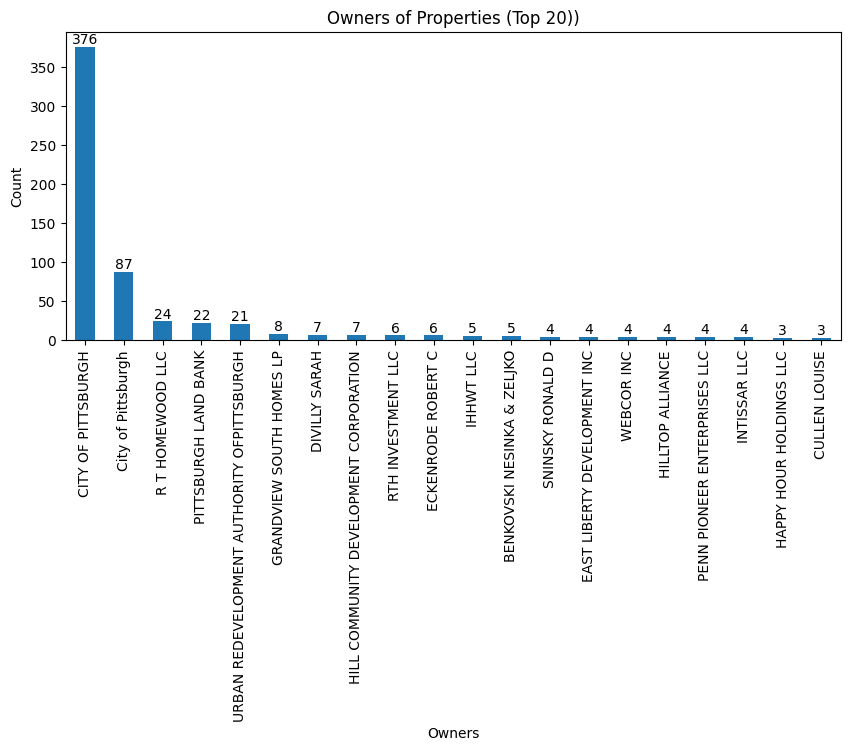

In [ ]:
# address counts
owner_counts = df['owner'].value_counts().nlargest(20)
# plot and label bars
owner_graph = owner_counts.plot(kind='bar', figsize=(10,4))
owner_graph.bar_label(owner_graph.containers[0])        # add the count labels
# design / details
plt.title('Owners of Properties (Top 20))')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

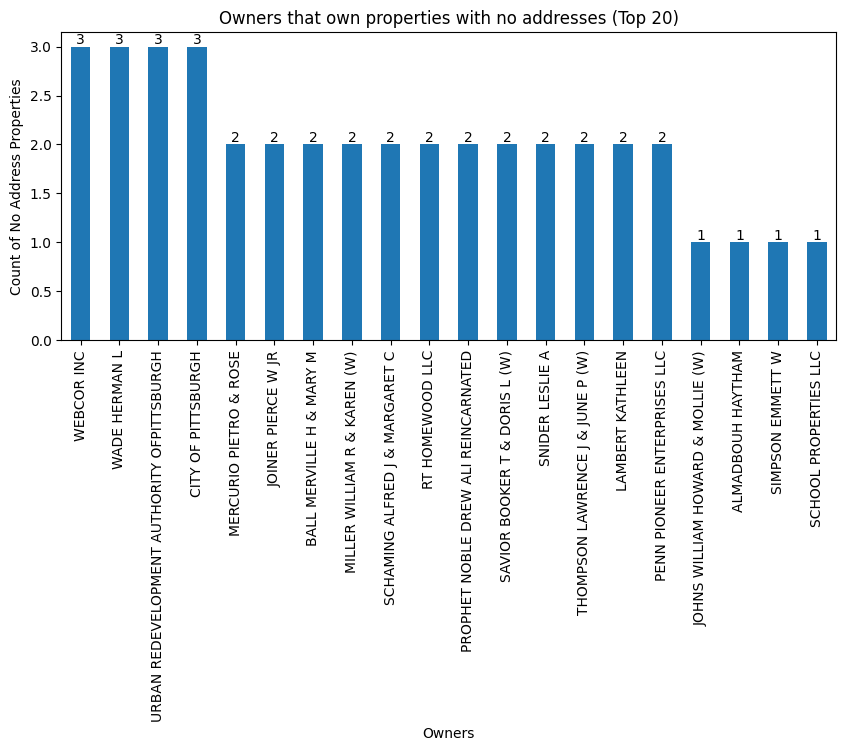

In [ ]:
# create new df with just no address values
no_add = "No primary address specified"
no_address_df = df[df['final_address'] == no_add].copy()

# owner counts in no address df
owners_count = no_address_df['owner'].value_counts().nlargest(20)
# plot and label bars
no_add_owner_graph = owners_count.plot(kind='bar', figsize=(10,4))
no_add_owner_graph.bar_label(no_add_owner_graph.containers[0])              # add the count labels
# design / details
plt.title('Owners that own properties with no addresses (Top 20)')
plt.xlabel("Owners")
plt.ylabel('Count of No Address Properties')
plt.show()

No more "No primary address specified" for the City of Pittsburgh owners. Some got defined to be owned by other individuals by the latest time of entry.